# Preliminary

Help

In [ ]:
# Documentation: https://ssc-datascience.github.io/
# https://medium.com/python-in-plain-english/scraping-tweets-with-tweepy-python-59413046e788
# https://towardsdatascience.com/how-to-scrape-tweets-from-twitter-59287e20f0f1

In [ ]:
# Help: https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/

#!pip install tweepy # python client for the official Twitter API
#!pip install textblob # python library for processing textual data

Needed to create a Twitter Developer account

Packages loading

In [1]:
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import tweepy
import json
import pandas as pd
import csv
import re
from textblob import TextBlob
import string
!pip install preprocessor
import preprocessor as p
import os
import time
import numpy as np
import nltk

  Created wheel for preprocessor: filename=preprocessor-1.1.3-cp36-none-any.whl size=4478 sha256=cf5b49e3f87d5b985840d0bfc92c2f589b46ccf8d8f38813b3ce46c52dbd288e
  Stored in directory: /root/.cache/pip/wheels/98/c1/a2/21fbcfd80d76576bbf148991a66f00730f541f265c7600000f
Successfully built preprocessor


In [2]:
import matplotlib.pyplot as plt #for plotting

In [3]:
# Twitter credentials
# Obtain them from your twitter developer account

consumer_key = "*****"
consumer_secret = "*****"

access_token = "*****"
access_token_secret = "*****"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth,wait_on_rate_limit=True)

In [4]:
def clean_tweet(tweet): 
        ''' 
        Utility function to clean tweet text by removing links, special characters using simple regex statements. 
        '''
        return ' '.join(re.sub("(\w+:\/\/\S+)", " ", tweet).split()) # (@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|

# Data

In [5]:
# Number of most recent tweets to be scraped

import datetime

count = 2000
startDate = datetime.datetime(2018, 1, 1, 0, 0, 0)
endDate = datetime.datetime(2020, 12, 31, 23, 59, 59)

In [6]:
username = 'Succes_MASRA'

try:     
 # Creation of query method using parameters
 tweets = tweepy.Cursor(api.user_timeline,id=username,tweet_mode='extended').items(count)
 
 # Pulling information from tweets iterable object
 tweets_list = [[tweet.created_at, tweet.id, clean_tweet(tweet.full_text)] for tweet in tweets if (tweet.full_text.find("RT @")<0)]
 #  and len(tweet.full_text)>0
 # Creation of dataframe from tweets list
 # Add or remove columns as you remove tweet information
 masra_tweets = pd.DataFrame(tweets_list)
 masra_tweets = masra_tweets[(startDate < masra_tweets[0]) & (masra_tweets[0] < endDate)]
 #masra_tweets = masra_tweets[masra_tweets[0] < endDate]
 masra_tweets.columns = ['date','id','tweet']
 #NotEmpty = [bool(masra_tweets[i,'tweet'].strip()) for i in masra_tweets.index]
 #masra_tweets = masra_tweets[NotEmpty]
 EmptyIndex = [i for i in masra_tweets.index if not masra_tweets.loc[i,'tweet']]
 masra_tweets = masra_tweets.drop(EmptyIndex)
except BaseException as e:
      # print error (if any) 
      print('failed on_status,',str(e))
      time.sleep(3)

In [7]:
username = 'saleh_kebzabo'

try:     
 # Creation of query method using parameters
 tweets = tweepy.Cursor(api.user_timeline,id=username,tweet_mode='extended').items(count)
 
 # Pulling information from tweets iterable object
 tweets_list = [[tweet.created_at, tweet.id, clean_tweet(tweet.full_text)] for tweet in tweets if (tweet.full_text.find("RT @")<0)]
 #and len(tweet.full_text)>0

 # Creation of dataframe from tweets list
 # Add or remove columns as you remove tweet information
 kebzabo_tweets = pd.DataFrame(tweets_list)
 kebzabo_tweets = kebzabo_tweets[(startDate < kebzabo_tweets[0]) & (kebzabo_tweets[0] < endDate)]
 #kebzabo_tweets = kebzabo_tweets[kebzabo_tweets[0] < endDate]
 
 kebzabo_tweets.columns = ['date','id','tweet']
 EmptyIndex = [i for i in kebzabo_tweets.index if not kebzabo_tweets.loc[i,'tweet']]
 kebzabo_tweets = kebzabo_tweets.drop(EmptyIndex)

except BaseException as e:
      # print error (if any) 
      print('failed on_status,',str(e))
      time.sleep(3)

In [8]:
kebzabo_tweets['tweet'] = [kebzabo_tweets.loc[i,'tweet'].replace("Covid19","Covid") for i in kebzabo_tweets.index]
kebzabo_tweets['tweet'] = [kebzabo_tweets.loc[i,'tweet'].replace("Deby","Déby") for i in kebzabo_tweets.index]

masra_tweets['tweet'] = [masra_tweets.loc[i,'tweet'].replace("Covid19","Covid") for i in masra_tweets.index]

In [10]:
!pip install deep_translator

In [11]:
# Translate into French tweets that are not in French
# Too many requests. Could not use this.

from deep_translator import GoogleTranslator

def TranslateToFrench(ListTweets):
  for i in ListTweets.index:
    if ListTweets.loc[i,'tweet']:
      if (TextBlob(ListTweets.loc[i,'tweet']).detect_language() != 'fr'):
        ListTweets.loc[i,'tweet'] = GoogleTranslator(source='auto', target='fr').translate(ListTweets.loc[i,'tweet'])
        time.sleep(3) # time limit on quotas https://cloud.google.com/translate/quotas?hl=en
  return ListTweets

masra_tweets['tweet'] = TranslateToFrench(masra_tweets)
kebzabo_tweets['tweet'] = TranslateToFrench(kebzabo_tweets)

#Sentiment analysis

In [13]:
!pip install textblob_fr
from textblob_fr import PatternTagger, PatternAnalyzer

     |████████████████████████████████| 563kB 5.2MB/s 


In [14]:
masra_sentiment = pd.DataFrame([TextBlob(text=masra_tweets.loc[i,'tweet'], pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment for i in masra_tweets.index])
masra_sentiment.columns = ['polarity', 'subjectivity'] # polarity,subjectivity
masra_sentiment['date_truncated'] = [masra_tweets.loc[i,'date'].date() for i in masra_tweets.index]

kebzabo_sentiment = pd.DataFrame([TextBlob(text=kebzabo_tweets.loc[i,'tweet'], pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment for i in kebzabo_tweets.index])
kebzabo_sentiment.columns = ['polarity', 'subjectivity'] # polarity,subjectivity
kebzabo_sentiment['date_truncated'] = [kebzabo_tweets.loc[i,'date'].date() for i in kebzabo_tweets.index]

Some descriptive statistics

In [15]:
print("There are {} tweets from Kebzabo and {} tweets from Masra. \n".format(kebzabo_tweets.shape[0],masra_tweets.shape[0]))

There are 476 tweets from Kebzabo and 703 tweets from Masra. 



Simple sentiment analysis

In [16]:
mycolors = {'masra1':'brown','kebzabo1':'turquoise','masra2':'red','kebzabo2':'aqua','masra3':'lightcoral','kebzabo3':'aquamarine'}

Text(0, 0.5, 'Polarity score')

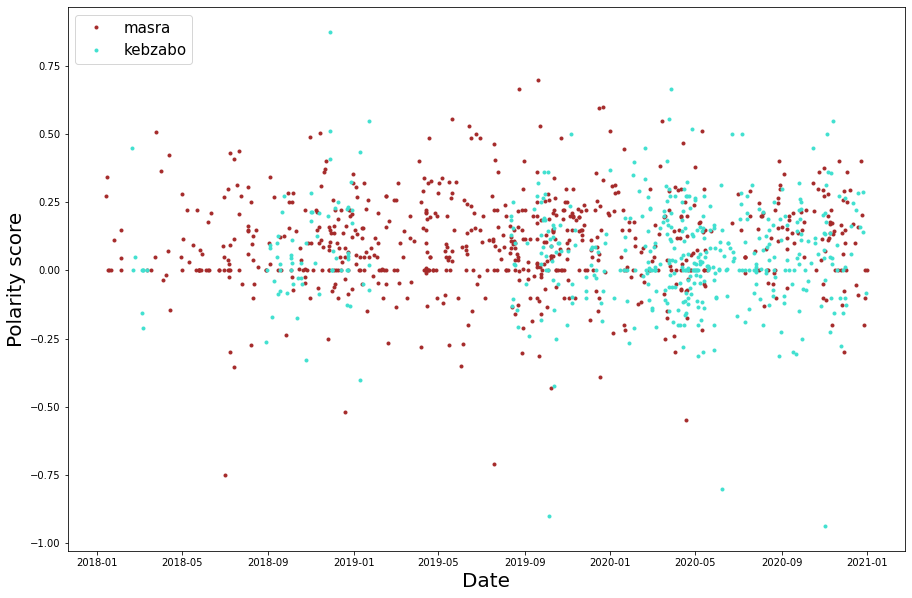

In [17]:
plt.figure(figsize=(15,10))
#plt.xlim(0,max(len(masra_tweets[0]),len(kebzabo_tweets[0])))

plt.plot(masra_sentiment['date_truncated'],masra_sentiment["polarity"],'.',color = mycolors['masra1'],label='masra')
plt.plot(kebzabo_sentiment['date_truncated'],kebzabo_sentiment["polarity"],'.',color = mycolors['kebzabo1'],label='kebzabo')

#plt.stackplot(range(len(year)),participations, colors = mycolors, labels=name[african_participant])

#plt.yticks(np.arange(0,sum(np.max(participations,axis=1)),15),fontsize=15)
#plt.xticks(np.arange(1,len(year),3),year[np.arange(1,len(year),3)][::-1],fontsize=15)

plt.legend(loc='upper left',fontsize=15)
plt.xlabel('Date',fontsize=20)
plt.ylabel('Polarity score',fontsize=20)

Text(0, 0.5, 'Subjectivity score')

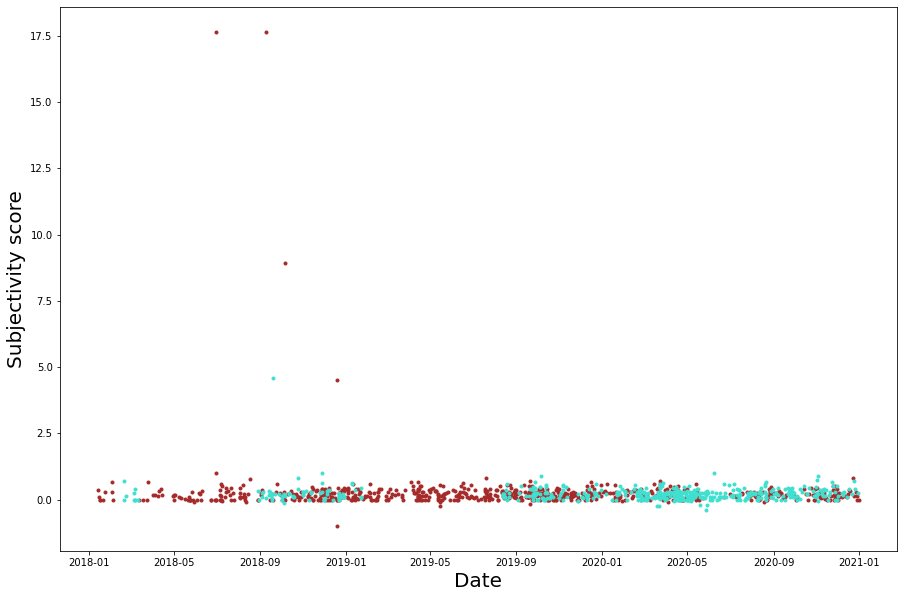

In [18]:
import matplotlib.pyplot as plt #for plotting

plt.figure(figsize=(15,10))
#plt.xlim(0,max(len(masra_tweets[0]),len(kebzabo_tweets[0])))

plt.plot(masra_sentiment['date_truncated'],masra_sentiment["subjectivity"],'.',color = mycolors['masra1'],label='masra')
plt.plot(kebzabo_sentiment['date_truncated'],kebzabo_sentiment["subjectivity"],'.',color = mycolors['kebzabo1'],label='kebzabo')

#plt.stackplot(range(len(year)),participations, colors = mycolors, labels=name[african_participant])

#plt.yticks(np.arange(0,sum(np.max(participations,axis=1)),15),fontsize=15)
#plt.xticks(np.arange(1,len(year),3),year[np.arange(1,len(year),3)][::-1],fontsize=15)

#plt.legend(loc='upper left',fontsize=15)
plt.xlabel('Date',fontsize=20)
plt.ylabel('Subjectivity score',fontsize=20)

In [19]:
# x-axis = number of words, y-axis = frequency/density 
# (example: Graph 2 and 3 at https://www.analyticsvidhya.com/blog/2020/11/fine-grained-sentiment-analysis-of-smartphone-review/)

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [20]:
masra_sentiment['nb words'] = [len(TextBlob(masra_tweets['tweet'][i]).words) for i in masra_tweets.index]
kebzabo_sentiment['nb words'] = [len(TextBlob(kebzabo_tweets['tweet'][i]).words) for i in kebzabo_tweets.index]

Descriptive statistics

In [21]:
print("There are {} positive tweets, {} negative tweets and {} neutral tweets from Masra. \n".format(sum(masra_sentiment['polarity']>0),sum(masra_sentiment['polarity']<0),sum(masra_sentiment['polarity']==0)))

There are 470 positive tweets, 129 negative tweets and 104 neutral tweets from Masra. 



In [ ]:
print("There are {} positive tweets, {} negative tweets and {} neutral tweets from Kebzabo. \n".format(sum(kebzabo_sentiment['polarity']>0),sum(kebzabo_sentiment['polarity']<0),sum(kebzabo_sentiment['polarity']==0)))

There are 279 positive tweets, 143 negative tweets and 54 neutral tweets from Kebzabo. 



In [ ]:
masra_pos_mean = np.mean(masra_sentiment['nb words'][masra_sentiment['polarity']>0]);masra_pos_std = np.std(masra_sentiment['nb words'][masra_sentiment['polarity']>0])
masra_neg_mean = np.mean(masra_sentiment['nb words'][masra_sentiment['polarity']<0]);masra_neg_std = np.std(masra_sentiment['nb words'][masra_sentiment['polarity']<0])

Proportion of 0.7233115468409586 Masra's positive tweets have between 28.063789656371675 and 41.75320380768061 words each. 



In [22]:
print("Proportion of {} Masra's negative tweets have between 30 and 40 words each. \n".
      format(sum((30<=masra_sentiment['nb words'])&(masra_sentiment['nb words']<=40)&(masra_sentiment['polarity']<0))/sum(masra_sentiment['polarity']<0)))

Proportion of 0.7364341085271318 Masra's negative tweets have between 30 and 40 words each. 



In [23]:
print("Proportion of {} Masra's positive tweets have between 30 and 40 words each. \n".
      format(sum((30<=masra_sentiment['nb words'])&(masra_sentiment['nb words']<=40)&(masra_sentiment['polarity']>0))/sum(masra_sentiment['polarity']>0)))

Proportion of 0.6340425531914894 Masra's positive tweets have between 30 and 40 words each. 



In [ ]:
sum((datetime.datetime(2020, 1, 1, 0, 0, 0) < kebzabo_tweets['date']) & (kebzabo_tweets['date'] < datetime.datetime(2020, 12, 31, 23, 59, 59)))/len(kebzabo_tweets)

0.6743697478991597

In [ ]:
sum((datetime.datetime(2020, 1, 1, 0, 0, 0) < masra_tweets['date']) & (masra_tweets['date'] < datetime.datetime(2020, 12, 31, 23, 59, 59)))/len(masra_tweets)

0.29445234708392604

In [25]:
np.mean(masra_sentiment['nb words']),np.mean(kebzabo_sentiment['nb words'])

(33.80512091038407, 38.55042016806723)

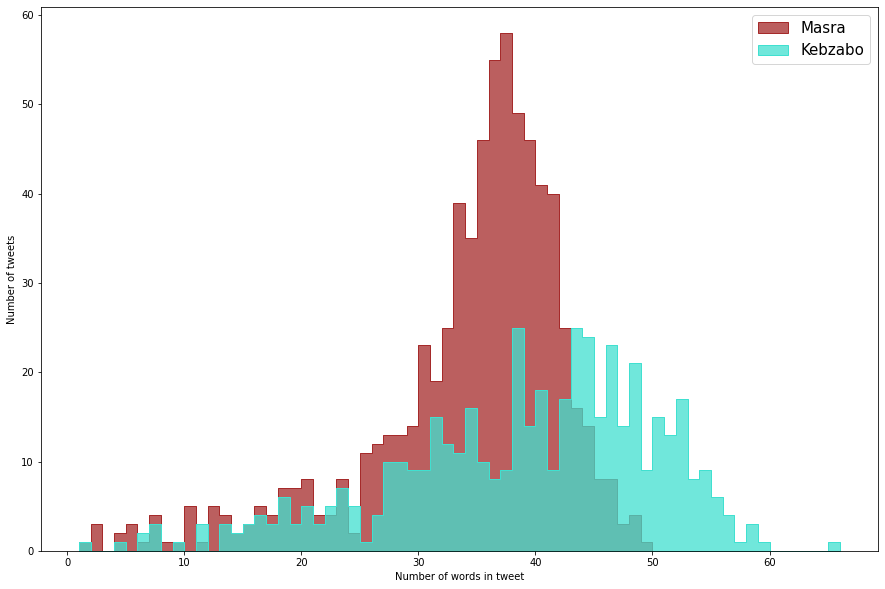

In [ ]:
import seaborn as sns

plt.figure(figsize=(15,10))

sns.histplot(masra_sentiment['nb words'], color = mycolors['masra1'], element="step",binwidth=1)
sns.histplot(kebzabo_sentiment['nb words'], color = mycolors['kebzabo1'], element="step",binwidth=1)

plt.legend(loc='upper right',fontsize=15,labels=['Masra','Kebzabo'])
plt.xlabel('Number of words in tweet')
plt.ylabel('Number of tweets')

plt.show()

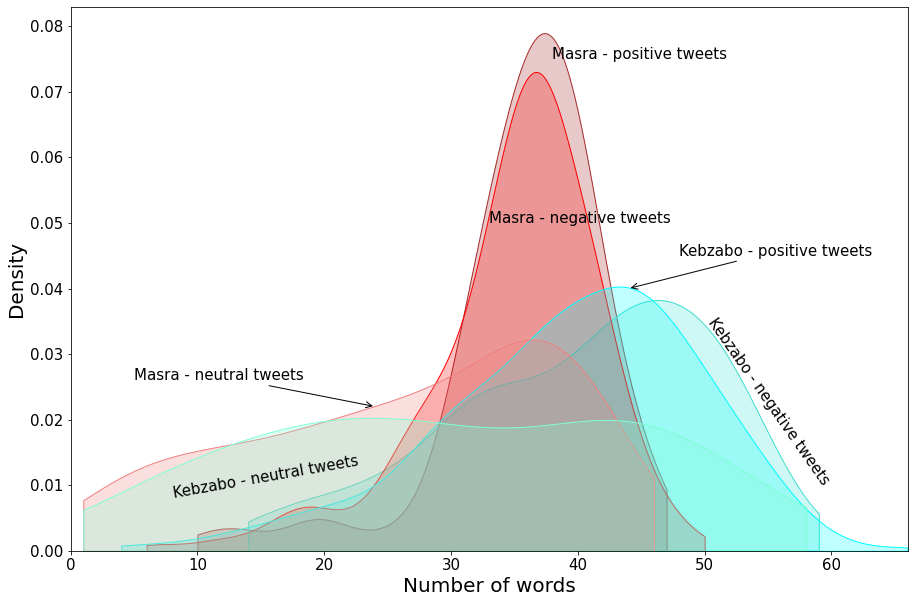

In [ ]:
# Density plot: Distribution of tweets according to their categories

plt.figure(figsize=(15,10))

Xlim = (0,max(max(masra_sentiment['nb words']),max(kebzabo_sentiment['nb words'])))
plt.yticks(np.arange(0,0.09,0.01),fontsize=15)
plt.xticks(np.arange(0,70,10),fontsize=15)
plt.xlabel('Number of words',fontsize=20)
plt.ylabel('Density',fontsize=20)

sns1 = sns.kdeplot(
   masra_sentiment['nb words'][masra_sentiment['polarity']<0],cut=0,color=mycolors['masra1'],
   fill=True, common_norm=False, palette="crest"
)
sns1.set(xlim=Xlim)
sns1.text(33,0.05,'Masra - negative tweets',fontsize=15)

sns2 = sns.kdeplot(
   kebzabo_sentiment['nb words'][kebzabo_sentiment['polarity']<0],cut=0,color=mycolors['kebzabo1'],
   fill=True, common_norm=False, palette="crest"
)
sns2.set(xlim=Xlim)
sns2.text(50,0.01,'Kebzabo - negative tweets',fontsize=15, rotation = -55)

#sns.fig.text(0.33, 1.02,'Above the plot', fontsize=20)

sns3 = sns.kdeplot(
   masra_sentiment['nb words'][masra_sentiment['polarity']>0],cut=0,color=mycolors['masra2'],
   fill=True, common_norm=False, palette="crest"
)
sns3.set(xlim=Xlim)
sns3.text(38,0.075,'Masra - positive tweets',fontsize=15)

sns4 = sns.kdeplot(
   kebzabo_sentiment['nb words'][kebzabo_sentiment['polarity']>0],cut=0,color=mycolors['kebzabo2'],
   fill=True, common_norm=False, palette="crest"
)
sns4.set(xlim=Xlim)
#sns4.text(44,0.04,'Kebzabo - positive tweets',fontsize=15)
sns4.annotate('Kebzabo - positive tweets',fontsize=15,
            xy=(44,0.04), #xycoords='data',
            xytext=(48,0.045), #textcoords='offset points',
            arrowprops=dict(arrowstyle="->"))

sns5 = sns.kdeplot(
   masra_sentiment['nb words'][masra_sentiment['polarity']==0],cut=0,color=mycolors['masra3'],
   fill=True, common_norm=False, palette="crest"
)
sns5.set(xlim=Xlim)
#sns5.text(5,0.026,'Masra - neutral tweets')
sns5.annotate('Masra - neutral tweets',fontsize=15,
            xy=(24, 0.022), #xycoords='data',
            xytext=(5,0.026), #textcoords='offset points',
            arrowprops=dict(arrowstyle="->"))

sns6 = sns.kdeplot(
   kebzabo_sentiment['nb words'][kebzabo_sentiment['polarity']==0],cut=0,color=mycolors['kebzabo3'],
   fill=True, common_norm=False, palette="crest"
)
sns6.set(xlim=Xlim)
sns6.text(8,0.008,'Kebzabo - neutral tweets', rotation = 10, fontsize=15)

#plt.legend(loc='upper right',fontsize=15,labels=['Masra-positive','Kebzabo-positive','Masra-negative','Kebzabo-negative','Masra-neutral','Kebzabo-neutral'])

plt.show()

Sentiment analysis using bigrams

In [ ]:
#from nltk import word_tokenize 
#nltk.download('punkt')
#from nltk.util import ngrams

#token = nltk.word_tokenize(''.join(masra_tweets.loc[1,'tweet']))
#bigram = list(ngrams(token, 2))
#sentiment = [TextBlob(' '.join(bigram[i]), pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment for i in range(len(bigram))]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Word cloud

In [ ]:
# Help: https://www.datacamp.com/community/tutorials/wordcloud-python

In [ ]:
import wordcloud
from wordcloud import WordCloud#, STOPWORDS, ImageColorGenerator
from PIL import Image

In [ ]:
mask = np.array(Image.open("/content/tchad_carte.jpg"))

#from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = set(stopwords.words('french')+stopwords.words('english'))
stopwords.update(["sans", "tout", "comme", "tous", "cette","c'est","ceux","n'est","ici","plus","où","d'un",
                  "d'une","si","qu'un","aussi","ça","la","toute","cela","ni","qu'on","chaque","dont","l'",
                  "très","donc", "quand","là","être","encore","après","contre","autre","autres","avoir","qu'il",
                  "entre","car","deux","non","toujours","quelque","quelques","depuis","fait","faire"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def CreateWordCloud(name):
  #tweets_all = " ".join(tweet for tweet in masra_tweets['tweet'])
  tweets_all = " ".join(tweet for tweet in eval(name.lower()+"_tweets['tweet']"))
  wordcloud = WordCloud(background_color="white", max_words=15,stopwords=stopwords,
                        contour_width=0.1,
                        random_state=1,
                        contour_color=mycolors[name.lower()+'1'],
                        collocations=True,# for bigrams analysis
                        mask=mask).generate(tweets_all)
  return wordcloud

In [ ]:
WordCloudMasra = CreateWordCloud('Masra')
WordCloudKebzabo = CreateWordCloud('Kebzabo')

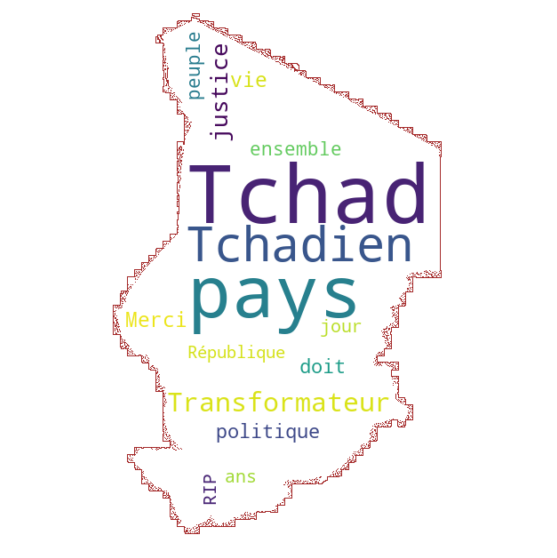

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(WordCloudMasra, interpolation='bilinear')
plt.axis("off")
plt.show()

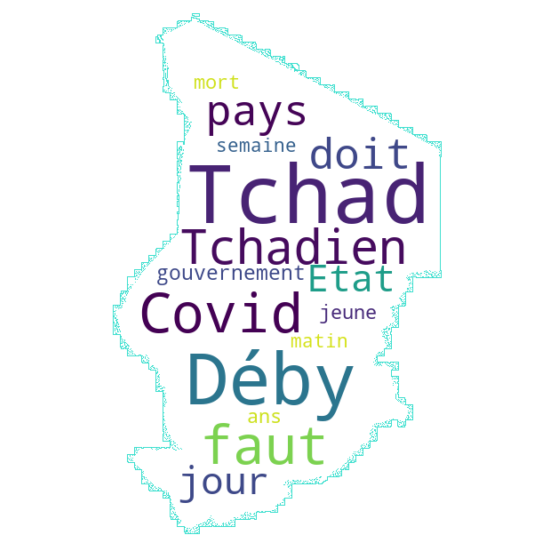

In [ ]:
plt.figure(figsize=(15,10))
plt.imshow(WordCloudKebzabo, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Words in common
set(WordCloudKebzabo.words_).intersection(set(WordCloudMasra.words_))

{'Tchad', 'Tchadien', 'ans', 'doit', 'jour', 'pays'}

In [ ]:
# Words that are frequent in Kebzabo's communication and not in Masra's
SymDiff = set(WordCloudKebzabo.words_).symmetric_difference(set(WordCloudMasra.words_))
set(WordCloudKebzabo.words_).intersection(set(SymDiff))

{'Covid',
 'Déby',
 'Etat',
 'faut',
 'gouvernement',
 'jeune',
 'matin',
 'mort',
 'semaine'}

In [ ]:
# Words that are frequent in Masra's communication and not in Kebzabo's
set(WordCloudMasra.words_).intersection(set(SymDiff))

{'Merci',
 'RIP',
 'République',
 'Transformateur',
 'ensemble',
 'justice',
 'peuple',
 'politique',
 'vie'}

Chi-square test on type of sentiment between tweets from Masra and Kebzabo

In [ ]:
from scipy.stats import chisquare

In [ ]:
masra_sentiment['polarity_cat'] = [float('nan') for y in range(len(masra_sentiment))]
masra_sentiment.loc[masra_sentiment['polarity']<0,'polarity_cat'] = 'negative'
masra_sentiment.loc[masra_sentiment['polarity']>0,'polarity_cat'] = 'positive'
masra_sentiment.loc[masra_sentiment['polarity']==0,'polarity_cat'] = 'neutral'

kebzabo_sentiment['polarity_cat'] = [float('nan') for y in range(len(kebzabo_sentiment))]
kebzabo_sentiment.loc[kebzabo_sentiment['polarity']<0,'polarity_cat'] = 'negative'
kebzabo_sentiment.loc[kebzabo_sentiment['polarity']>0,'polarity_cat'] = 'positive'
kebzabo_sentiment.loc[kebzabo_sentiment['polarity']==0,'polarity_cat'] = 'neutral'

In [ ]:
chisquare(masra_sentiment['polarity_cat'].value_counts(),kebzabo_sentiment['polarity_cat'].value_counts())

Power_divergenceResult(statistic=115.37559523809523, pvalue=8.841130904120798e-26)